<a href="https://colab.research.google.com/github/PranavSingla122/Nasal-Fracture-classification/blob/main/Nasal_fracture_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import timm
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast


In [ ]:

# Define dataset path
dataset_path = "/content/drive/MyDrive/Dataset"  # Ensure correct path

# Image parameters
img_size = (224, 224)
batch_size = 32
train_ratio = 0.8

# Data transformations
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, shear=15),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.GaussianBlur(kernel_size=(5, 5)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.3, value='random')
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [ ]:

# Define Transfer Learning Model
class NasalFractureModel(nn.Module):
    def __init__(self):
        super(NasalFractureModel, self).__init__()
        self.model = timm.create_model("resnet34", pretrained=True)
        self.model.fc = nn.Linear(512, 1)

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NasalFractureModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
scaler = GradScaler()

# Training loop
epochs = 50
early_stopping_patience = 10
best_val_loss = float("inf")
stopping_counter = 0

train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device).view(-1, 1)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device).view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_nasal_fracture_model.pth")
        stopping_counter = 0
    else:
        stopping_counter += 1
        if stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load("best_nasal_fracture_model.pth"))
model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.cpu().numpy()
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        y_scores.extend(probs)
        y_true.extend(labels)

# Find optimal threshold
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.3f}")

# Recalculate predictions using optimal threshold
y_pred = (np.array(y_scores) > optimal_threshold).astype(int)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-1-7960da3815af>:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-1-7960da3815af>:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 - Train Loss: 0.6929, Test Loss: 0.6901
Epoch 2/50 - Train Loss: 0.6908, Test Loss: 0.6869
Epoch 3/50 - Train Loss: 0.6839, Test Loss: 0.6888
Epoch 4/50 - Train Loss: 0.6781, Test Loss: 0.6787
Epoch 5/50 - Train Loss: 0.6694, Test Loss: 0.6668
Epoch 6/50 - Train Loss: 0.6450, Test Loss: 0.6420
Epoch 7/50 - Train Loss: 0.6148, Test Loss: 0.6552
Epoch 8/50 - Train Loss: 0.6127, Test Loss: 0.6094
Epoch 9/50 - Train Loss: 0.5859, Test Loss: 0.6039
Epoch 10/50 - Train Loss: 0.5786, Test Loss: 0.5860
Epoch 11/50 - Train Loss: 0.5640, Test Loss: 0.5810
Epoch 12/50 - Train Loss: 0.5502, Test Loss: 0.5982
Epoch 13/50 - Train Loss: 0.5443, Test Loss: 0.6018
Epoch 14/50 - Train Loss: 0.5485, Test Loss: 0.5760
Epoch 15/50 - Train Loss: 0.5390, Test Loss: 0.5510
Epoch 16/50 - Train Loss: 0.5387, Test Loss: 0.5950
Epoch 17/50 - Train Loss: 0.5279, Test Loss: 0.5487
Epoch 18/50 - Train Loss: 0.5235, Test Loss: 0.6026
Epoch 19/50 - Train Loss: 0.5273, Test Loss: 0.5722
Epoch 20/50 - Train L

<ipython-input-1-7960da3815af>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_nasal_fracture_model.pth"))


Optimal Threshold: 0.511


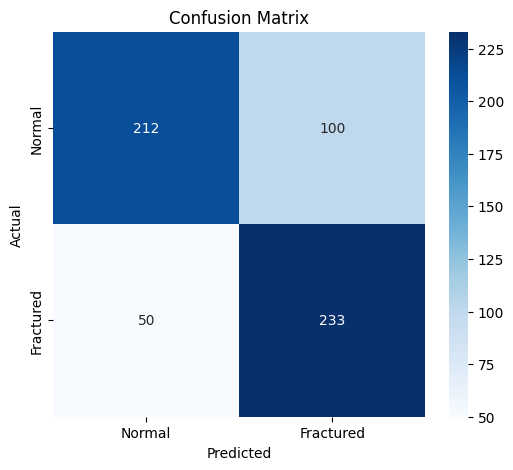

Classification Report:
              precision    recall  f1-score   support

      Normal       0.81      0.68      0.74       312
   Fractured       0.70      0.82      0.76       283

    accuracy                           0.75       595
   macro avg       0.75      0.75      0.75       595
weighted avg       0.76      0.75      0.75       595



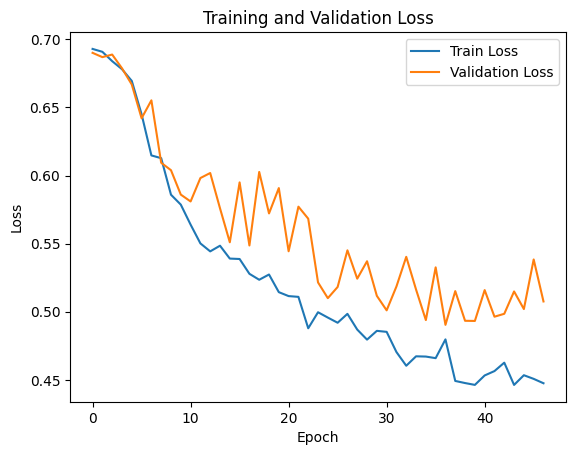

AUC-ROC Score: 0.821


In [ ]:

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fractured'], yticklabels=['Normal', 'Fractured'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Fractured']))

# Plot training progress
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# AUC-ROC Score
roc_auc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score: {roc_auc:.3f}")
